### Salary Prediction Classification

Purpose: Classification on Salary whether less than 50K or greater than 50K

In [104]:
#import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [198]:
#import data

df = pd.read_csv('../data/salary.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Some Descriptives

- Printng DataFrame Size
- checking for null values
- checking for cardinality in my categorical columns
- checking for outliers

In [6]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

The dataset has 32561 rows and 15 columns


In [5]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
df.salary.value_counts()  #checking target distribution

 <=50K    24720
 >50K      7841
Name: salary, dtype: int64

In [10]:
df.isnull().sum()  #checking for null values

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

In [18]:
df.dtypes  #checking for column types

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

In [187]:
## observations 
## ==> the target column is imbalanced. The <=50k category is 3 times the >50k category
## ==> no null values detected with isnull but are there other null representations? --- (yes, there are!)
## ==> For my quick and dirty step, I will use all numerical columns and education, relationship, race only.
## ==> capital-gains and capital-loss and hours per week all have outliers ---> obvious from the max value printed
## ==> capital gains and capital loss all have huge zeros! up until the 75th percentile, so will remove them


for cols in df.select_dtypes(include=['object']):
    print(df[cols].value_counts())
    print(cols)

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
workclass
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
education
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64
marital-status
 Prof-specialty       4140
 Craft-r

In [59]:
cat_columns = ['education','relationship','race','workclass','occupation','native country']
num_columns = ['age','fnlwgt','education-num','hours-per-week']  #select needed numerical columns

#### iterate on data
- remove outliers in hours per week - beyond the 95th percentile
- deal with missing values in workclass, occupation and native country add them in 

In [182]:
#  drop all rows less than this number
pct = np.percentile(df.loc[:, 'hours-per-week'].fillna(np.mean(df.loc[:, 'hours-per-week'])), 95)
pct

60.0

In [184]:
df['hours-per-week'] = df['hours-per-week'].clip(upper = pct)

In [190]:
#replacing missing values

df.loc[df['workclass'] == '?', 'workclass'] = 'No workclass'
df.loc[df['native-country'] == '?', 'native-country'] = 'No native-country'
df.loc[df['occupation'] == '?', 'occupation'] = 'No occupation'

###  Visualizations

- trying to understand the data better
- looking to understand the scales in the data

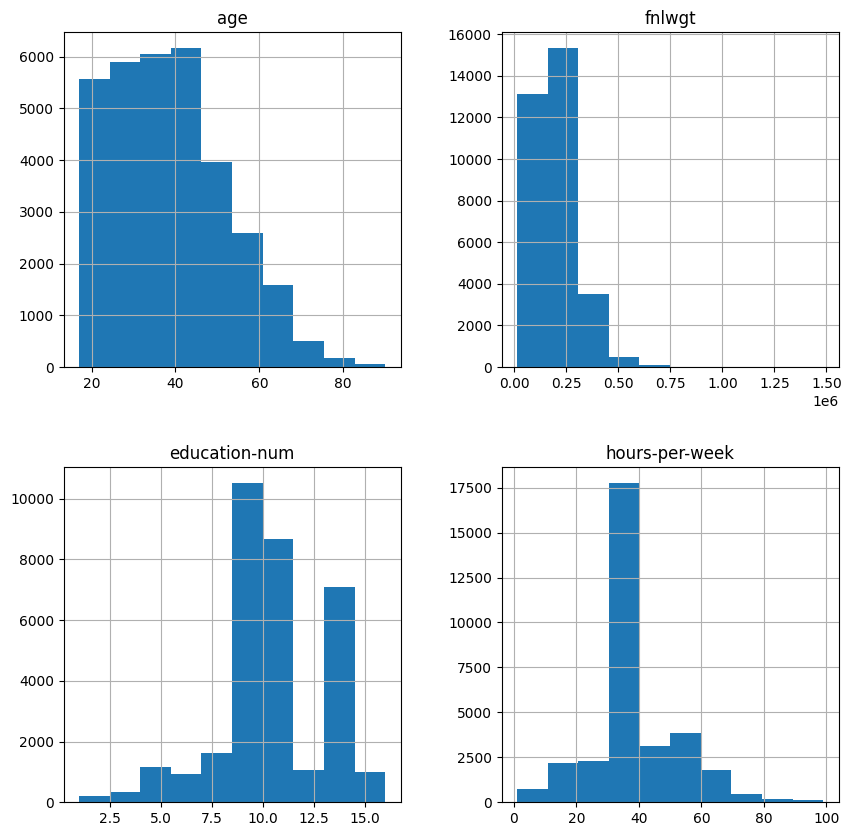

In [66]:
hist_distr = df[num_columns].hist(figsize = (10, 10))

In [67]:
#observations
## -- I want to scale the hours per week, and age

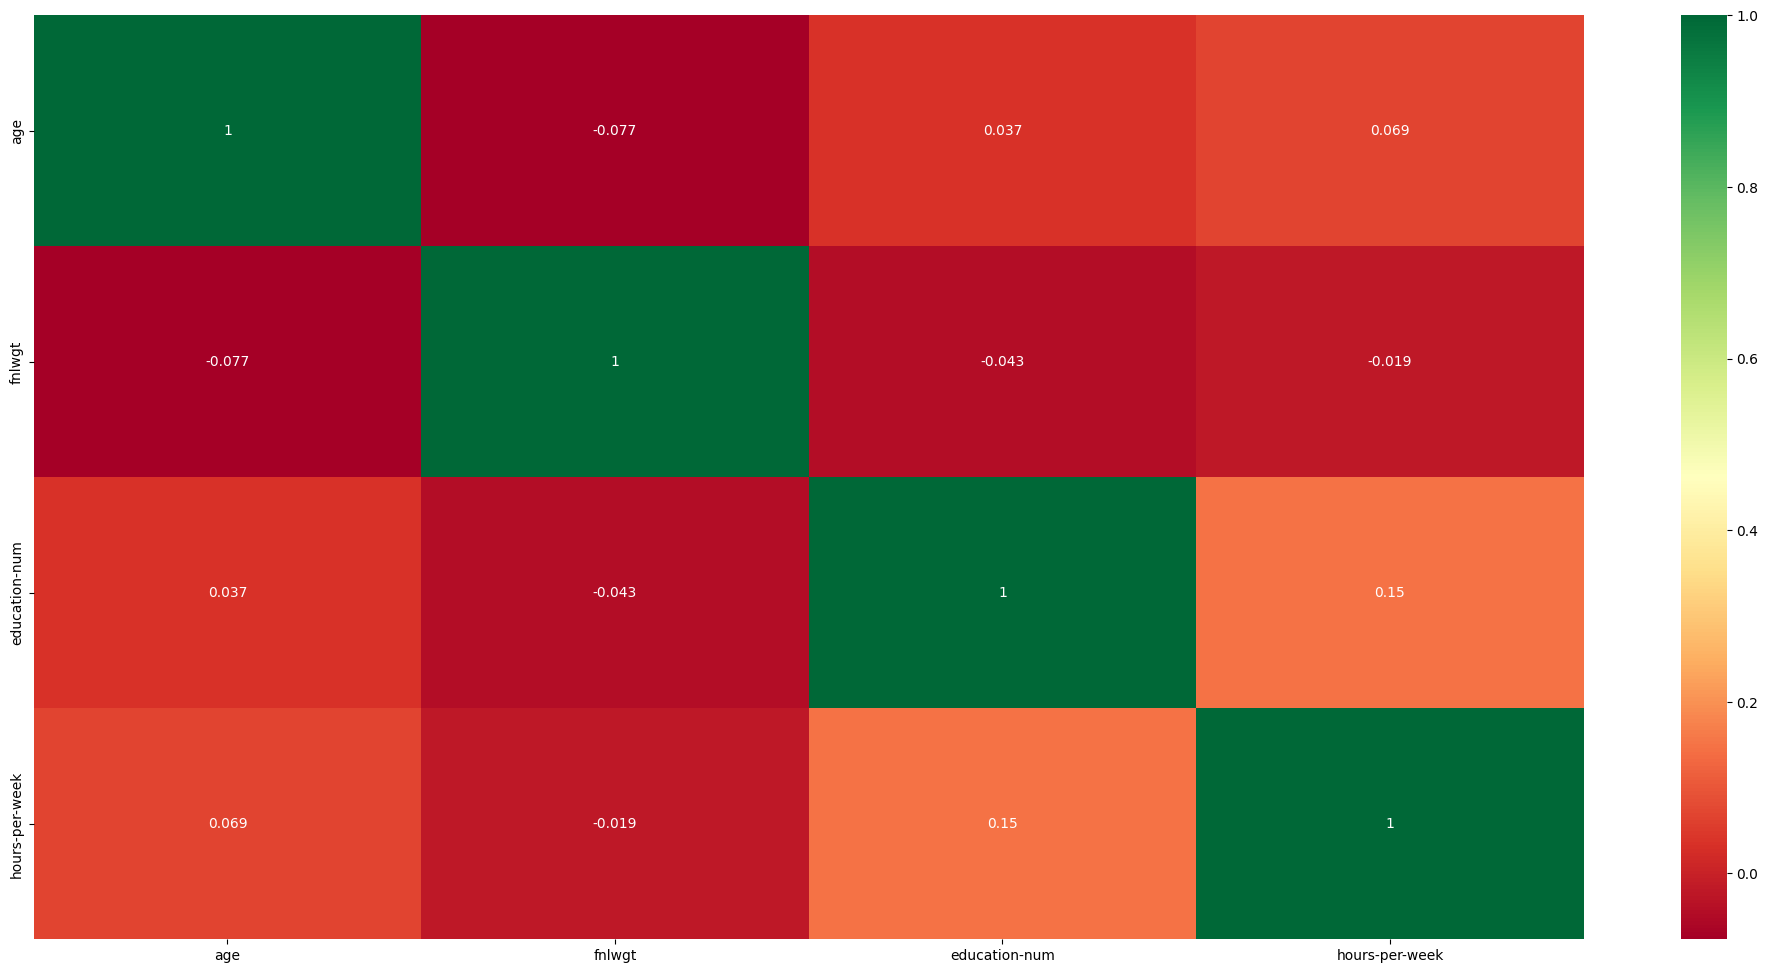

In [62]:
#check for correlation matrix

corrmat = df[cat_columns + num_columns].corr()   #get correlations table
top_corr_features = corrmat.index
plt.figure(figsize=(25,12))
g=sns.heatmap(df[cat_columns + num_columns].corr(),annot=True,cmap="RdYlGn")   #plot heat map

### Model Development

In [147]:
#assign X and y

X = df[cat_columns + num_columns]
y = df.salary


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
from sklearn.preprocessing import LabelEncoder

le_y = LabelEncoder()
le_y.fit(y_train)

LabelEncoder()

In [149]:
#encode the target column
y_train = le_y.transform(y_train)
y_test = le_y.transform(y_test)

In [150]:
#test inverse transform
le_y.inverse_transform([0,1])

array([' <=50K', ' >50K'], dtype=object)

#### Prepocessing
- No missing values in num_colums so no need for the simple imputer
- encodings ---> education has 16 Categories, relationship has 6 categories and race has 5 categories
- First I use the ordinal encoder for them all

In [216]:
#instantiate the Label Encoder
le = ce.OrdinalEncoder(cols=['education', 'relationship', 'race'])


#encode columns with the 
ce_te = ce.TargetEncoder(cols=['workclass','occupation','native-country'])

In [213]:
#create numerical transformer
numerical_transformer = ColumnTransformer([
                            ('scaler', MinMaxScaler(), ['age','hours-per-week'])
                                            ], remainder='passthrough')

#create categorical transformer
categorical_transformer = Pipeline(steps=[('ord_encoder',le)
                                        ])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)
    ])

##### Logistic Regression

In [214]:
lr = LogisticRegression()

In [215]:
#model pipeline
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('linear_model', lr)
                             ])

# Preprocessing of training data, fit model 
lr_pipe.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
lr_preds = lr_pipe.predict(X_test)

In [208]:
# Evaluate the model
score = f1_score(y_test, lr_preds, average='macro')
print('F1 Score for the logistic regression Model is', score)

F1 Score for the logistic regression Model is 0.4314273243125273


##### Random Forest

In [143]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5, random_state=42)

In [144]:
#model pipeline
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('random forest', rf)
                             ])

# Preprocessing of training data, fit model 
rf_pipe.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
rf_preds = rf_pipe.predict(X_test)

In [145]:
# Evaluate the model
score = f1_score(y_test, rf_preds, average='macro')
print('F1 Score for the Random Forest Model is', score)

F1 Score for the Random Forest Model is 0.6941462110829753


#### Cross Validation

In [217]:
#test on cross validation
y_ = le_y.transform(y)
crv_scores = cross_val_score(rf_pipe, X, y_,
                              cv=5,
                              scoring='f1')

print("F1 Score from Cross Validation", crv_scores)

F1 Score from Cross Validation [0.48407643 0.51501057 0.51286377 0.52793995 0.51406972]


#### Iterate on Model

optimizing on the Model we will perform a grid search cv on the hyper-parameter space
- max_depth --> (3,5)
- n_estimators --> (100,300)
- cv only 3 due to run time

In [158]:
parameters = {'n_estimators'  : [100, 200, 300],
'max_depth'  : [3, 4, 5]}

In [176]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

cv_results_ = make_pipeline(preprocessor, 
                    GridSearchCV(RandomForestClassifier(),
                                 param_grid=parameters,scoring='f1',cv=3))

cv_results_.fit(X, y_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('scaler',
                                                                                   MinMaxScaler(),
                                                                                   ['age',
                                                                                    'hours-per-week'])]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('ord_encoder',
                                                                   OrdinalEnc

In [177]:
cv_results_['gridsearchcv'].cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [178]:
cv_results_['gridsearchcv'].cv_results_['params']

[{'max_depth': 3, 'n_estimators': 100},
 {'max_depth': 3, 'n_estimators': 200},
 {'max_depth': 3, 'n_estimators': 300},
 {'max_depth': 4, 'n_estimators': 100},
 {'max_depth': 4, 'n_estimators': 200},
 {'max_depth': 4, 'n_estimators': 300},
 {'max_depth': 5, 'n_estimators': 100},
 {'max_depth': 5, 'n_estimators': 200},
 {'max_depth': 5, 'n_estimators': 300}]

In [179]:
cv_results_['gridsearchcv'].cv_results_['mean_test_score']

array([0.4212204 , 0.33683862, 0.33717144, 0.50483956, 0.5079072 ,
       0.50877488, 0.51405558, 0.51724611, 0.51720439])